Projek UAS

Name		: Najwa Kaila Nur Alif

Nim		: 1306622047

Course 	: Pengantar Pembelajaran Mesin dalam Fisika (3 SKS)

Lecturer 	: Dr. B. Heru Iswanto


# Import Library

In [1]:
# ===== 1. Built-in Python Modules =====
import os                                # Operasi file dan direktori
import re                                # Regular expression
from glob import glob                    # Pencarian file dengan pola
from collections import defaultdict, Counter  # Struktur data untuk menghitung & mengelompokkan

# ===== 2. Scientific & Data Manipulation Libraries =====
import numpy as np                       # Operasi numerik & array
import pandas as pd                      # Manipulasi data tabular (DataFrame)
from scipy import stats                  # Fungsi statistik umum
from scipy.stats import skew, kurtosis   # Skewness dan kurtosis
from scipy.integrate import simpson      # Integrasi numerik
from scipy.fft import fft                # Fast Fourier Transform
import pywt                              # Wavelet Transform

# ===== 3. Visualization Libraries =====
import matplotlib.pyplot as plt          # Visualisasi grafik dasar
import seaborn as sns                    # Visualisasi statistik yang estetis
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting (untuk visualisasi PCA 3D)

# ===== 4. Scikit-Learn: Model & Preprocessing =====
from sklearn.svm import SVC                            # Support Vector Machine
from sklearn.pipeline import Pipeline                  # Untuk membungkus preprocessing dan model
from sklearn.model_selection import (
    GridSearchCV, LeaveOneOut, cross_val_predict       # Tuning & cross-validation
)
from sklearn.preprocessing import (
    LabelEncoder, StandardScaler                       # Preprocessing fitur dan label
)
from sklearn.decomposition import PCA                  # Principal Component Analysis
from sklearn.feature_selection import mutual_info_classif  # Seleksi fitur berbasis MI

# ===== 5. Scikit-Learn: Evaluation Metrics =====
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, roc_curve
)
from sklearn.utils import resample                     # Untuk upsampling/downsampling


# Load Data Raw

In [4]:
# Load semua data 
folder_raw = 'UAS/Data_Raw'

# Ambil semua file csv
file_paths_raw = [os.path.join(folder_raw, f) for f in os.listdir(folder_raw) if f.endswith('.csv')]

# Fungsi untuk ekstrak nomor dari nama file
def extract_number(filename):
    match = re.search(r'_(A|B)_(\d+)_', filename)
    if match:
        label = match.group(1)
        number = int(match.group(2))
        return (label, number)
    return ('Z', 999)  # Jika gagal, letakkan di akhir

# Urutkan berdasarkan label dan angka
file_paths_trimmed_sorted = sorted(file_paths_raw, key=lambda x: extract_number(os.path.basename(x)))

for path in file_paths_trimmed_sorted:
    df = pd.read_csv(path)
    
# Print Dataframe
df


,time(s),F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,Temp,Humid
0,0.0,2015.000,781.000,1454.875,1771.625,1839.625,2491.125,248.375,1368.250,2017.250,1621.000,37.09,44.98
1,0.1,2015.125,781.000,1454.875,1771.750,1839.625,2491.000,248.375,1368.250,2017.250,1621.000,37.09,44.92
2,0.2,2015.250,781.000,1454.875,1771.875,1839.625,2490.875,248.375,1368.375,2017.375,1620.875,37.09,44.97
3,0.3,2015.250,781.000,1454.875,1772.000,1839.500,2490.750,248.500,1368.500,2017.250,1620.875,37.10,45.00
4,0.4,2015.375,781.125,1454.875,1772.250,1839.375,2490.625,248.500,1368.625,2017.375,1620.750,37.08,44.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2696,269.6,2020.625,786.750,1457.625,1720.625,1820.250,2474.625,250.500,1336.250,2013.000,1581.125,37.26,43.26
2697,269.7,2020.625,786.875,1457.625,1720.500,1820.250,2474.625,250.375,1336.250,2012.875,1581.125,37.24,43.29
2698,269.8,2020.625,786.875,1457.500,1720.500,1820.250,2474.500,250.500,1336.125,2012.875,1581.125,37.23,43.24
2699,269.9,2020.500,786.875,1457.625,1720.500,1820.250,2474.500,250.375,1336.000,2012.750,1581.000,37.24,43.22


In [ ]:
# Drop kolom Temp dan Humid 
df = df.drop(columns=['Temp', 'Humid'], errors='ignore')
df

# Baseline

In [5]:
# Folder input dan output
folder_trimmed = 'UAS/Data_Raw'
folder_baseline = 'UAS/Data_Baseline'

# Buat folder output jika belum ada
if not os.path.exists(folder_baseline):
    os.makedirs(folder_baseline)

# Fungsi baseline correction pada dataframe
def baseline_correction(df):
    sensor_cols = df.columns[1:]  # Kolom sensor, kecuali kolom waktu (kolom 0)
    df_corrected = df.copy()
    for col in sensor_cols:
        baseline_value = df[col].iloc[0]
        df_corrected[col] = df[col] - baseline_value
    return df_corrected

# Fungsi plot untuk visualisasi (opsional, bisa dipakai untuk satu file contoh)
def plot_sensors(df, title):
    time = df.iloc[:, 0]
    sensor_cols = df.columns[1:]
    plt.figure(figsize=(12, 6))
    for col in sensor_cols:
        plt.plot(time, df[col], label=col)
    plt.title(title)
    plt.xlabel('Waktu (detik)')
    plt.ylabel('Respon Sensor')
    plt.legend(loc='upper right')
    plt.show()
    
# Proses semua file di folder_trimmed
files = [f for f in os.listdir(folder_trimmed) if f.endswith('.csv')]

for file in files:
    file_path = os.path.join(folder_trimmed, file)
    df = pd.read_csv(file_path)
    df_baseline = baseline_correction(df)

    # Simpan dengan nama file ditambah "_baseline" sebelum ekstensi
    filename_wo_ext, ext = os.path.splitext(file)
    save_path = os.path.join(folder_baseline, f"{filename_wo_ext}_baseline{ext}")
    df_baseline.to_csv(save_path, index=False)
    print(f"File {file} sudah di-baseline dan disimpan ke {save_path}")


File A_1.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_1_baseline.csv
File A_10.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_10_baseline.csv
File A_11.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_11_baseline.csv
File A_12.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_12_baseline.csv
File A_13.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_13_baseline.csv
File A_14.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_14_baseline.csv
File A_15.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_15_baseline.csv
File A_16.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_16_baseline.csv
File A_17.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_17_baseline.csv
File A_18.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_18_baseline.csv
File A_19.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_19_baseline.csv
File A_2.csv sudah di-baseline dan disimpan ke UAS/Data_Baseline\A_2_baseline.

# Trim Data

In [23]:
# Input dan Output Data 
folder_baseline = 'UAS/Data_Baseline'
folder_baseline_trimmed = 'UAS/Data_Crop'

# Buat folder output jika belum ada
if not os.path.exists(folder_baseline_trimmed):
    os.makedirs(folder_baseline_trimmed)

# Fungsi baseline correction (jika ingin pakai lagi, kalau cuma trimming bisa dihilangkan)
def baseline_correction(df):
    sensor_cols = df.columns[1:]  # Kolom sensor kecuali kolom waktu
    df_corrected = df.copy()
    for col in sensor_cols:
        baseline_value = df[col].iloc[0]
        df_corrected[col] = df[col] - baseline_value
    return df_corrected

# Ambil semua file CSV
files_baseline = [f for f in os.listdir(folder_baseline) if f.endswith('.csv')]

# Buat counter untuk nomor urut per label
counter = defaultdict(int)

# Fungsi untuk mengambil label dari nama file (misalnya: "A" dari "A_data.csv")
def extract_label(filename):
    return filename.split('_')[0]

for file in sorted(files_baseline):
    file_path = os.path.join(folder_baseline, file)
    df = pd.read_csv(file_path)

    # Ambil kolom waktu
    time_col = df.columns[0]

    # Trimming data: waktu antara 10–30 detik
    df_trimmed = df[(df[time_col] >= 10) & (df[time_col] <= 30)].reset_index(drop=True)

    # Ambil label
    label = extract_label(file)

    # Tambahkan nomor urut untuk label ini
    counter[label] += 1
    nomor_urut = f"{counter[label]:02d}"  # Format dua digit

    # Simpan dengan format nama baru
    new_filename = f"{label}_{nomor_urut}_1030crop.csv"
    save_path = os.path.join(folder_baseline_trimmed, new_filename)
    df_trimmed.to_csv(save_path, index=False)


In [24]:
# Folder hasil trimming
folder_crop = 'UAS/Data_Crop'

# Ambil semua file csv di folder
file_paths_crop = [os.path.join(folder_crop, f) for f in os.listdir(folder_crop) if f.endswith('.csv')]

# Fungsi untuk ekstrak label dan nomor urut dari nama file, misal: A_01_1030crop.csv
def extract_number(filename):
    match = re.match(r'([A-Z])_(\d+)_', filename)
    if match:
        label = match.group(1)
        number = int(match.group(2))
        return (label, number)
    return ('Z', 999)  # File tidak dikenali strukturnya, diletakkan di akhir

# Urutkan berdasarkan label dan nomor urut
file_paths_crop_sorted = sorted(file_paths_crop, key=lambda x: extract_number(os.path.basename(x)))

# Tampilkan durasi
print(f"{'File':30} | {'Waktu Mulai (detik)':>18} | {'Waktu Akhir (detik)':>18} | {'Durasi (detik)':>14}")
print("-"*85)

for file_path in file_paths_crop_sorted:
    df = pd.read_csv(file_path)
    time_start = df['time(s)'].iloc[0]
    time_end = df['time(s)'].iloc[-1]
    duration = time_end - time_start
    print(f"{os.path.basename(file_path):30} | {time_start:18.3f} | {time_end:18.3f} | {duration:14.3f}")


File                           | Waktu Mulai (detik) | Waktu Akhir (detik) | Durasi (detik)
-------------------------------------------------------------------------------------
A_01_1030crop.csv              |             10.000 |             30.000 |         20.000
A_02_1030crop.csv              |             10.000 |             30.000 |         20.000
A_03_1030crop.csv              |             10.000 |             30.000 |         20.000
A_04_1030crop.csv              |             10.000 |             30.000 |         20.000
A_05_1030crop.csv              |             10.000 |             30.000 |         20.000
A_06_1030crop.csv              |             10.000 |             30.000 |         20.000
A_07_1030crop.csv              |             10.000 |             30.000 |         20.000
A_08_1030crop.csv              |             10.000 |             30.000 |         20.000
A_09_1030crop.csv              |             10.000 |             30.000 |         20.000
A_10_1030cro

# Ekstraksi Fitur

In [27]:
# Load Data
folder_crop = 'UAS/Data_Crop'
files = [f for f in os.listdir(folder_crop) if f.endswith('.csv')]

# List untuk simpan hasil fitur
list_statistik = []
list_bentuk = []
list_frekuensi = []
list_temporal = []

# Tentukan sensor yang ingin diproses
sensor_target = [f'F{i}' for i in range(1, 11)]  # F1 sampai F10

for file in files:
    path = os.path.join(folder_crop, file)
    df = pd.read_csv(path)
    
    # Ambil kolom waktu
    time = df.iloc[:, 0].values
    
    # Tentukan label berdasarkan nama file
    if 'A' in file.upper():
        label = 'A'
    elif 'B' in file.upper():
        label = 'B'
    else:
        label = 'Unknown'

    # Filter sensor sesuai nama yang diinginkan dan yang ada di df
    sensors = [s for s in sensor_target if s in df.columns]
    
    fitur_stat = {'file': file, 'label': label}
    fitur_bentuk = {'file': file, 'label': label}
    fitur_freq = {'file': file, 'label': label}
    fitur_temp = {'file': file, 'label': label}
    
    for sensor in sensors:
        data = df[sensor].values
        
        # --- Statistik ---
        fitur_stat[f'{sensor}_mean'] = np.mean(data)
        fitur_stat[f'{sensor}_max'] = np.max(data)
        fitur_stat[f'{sensor}_median'] = np.median(data)
        fitur_stat[f'{sensor}_std'] = np.std(data)
        fitur_stat[f'{sensor}_skew'] = skew(data)
        fitur_stat[f'{sensor}_kurtosis'] = kurtosis(data)
        
        # --- Bentuk ---
        fitur_bentuk[f'{sensor}_auc'] = simpson(y=data, x=time)
        grad = np.gradient(data, time)
        fitur_bentuk[f'{sensor}_gradmax'] = np.max(np.abs(grad))
        
        # --- Frekuensi ---
        n = len(data)
        yf = fft(data)
        yf_mag = np.abs(yf[:n//2])
        fitur_freq[f'{sensor}_fft_max_mag'] = np.max(yf_mag)
        
        coeffs = pywt.wavedec(data, 'db4', level=1)
        cD1 = coeffs[1]
        fitur_freq[f'{sensor}_dwt_energy'] = np.sum(cD1**2)
        
        # --- Temporal ---
        idx_peak = np.argmax(data)
        fitur_temp[f'{sensor}_time_to_peak'] = time[idx_peak]
    
    list_statistik.append(fitur_stat)
    list_bentuk.append(fitur_bentuk)
    list_frekuensi.append(fitur_freq)
    list_temporal.append(fitur_temp)

# Simpan hasil ke CSV
os.makedirs('UAS/Ekstraksi_Fitur', exist_ok=True)
pd.DataFrame(list_statistik).to_csv('UAS/Ekstraksi_Fitur/fitur_statistik.csv', index=False)
pd.DataFrame(list_bentuk).to_csv('UAS/Ekstraksi_Fitur/fitur_bentuk.csv', index=False)
pd.DataFrame(list_frekuensi).to_csv('UAS/Ekstraksi_Fitur/fitur_frekuensi.csv', index=False)
pd.DataFrame(list_temporal).to_csv('UAS/Ekstraksi_Fitur/fitur_temporal.csv', index=False)

print("Ekstraksi fitur selesai dan disimpan ke folder Ekstraksi_Fitur.")

Ekstraksi fitur selesai dan disimpan ke folder Ekstraksi_Fitur.


In [28]:
stat = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_statistik.csv')
stat

,file,label,F1_mean,F1_max,F1_median,F1_std,F1_skew,F1_kurtosis,F2_mean,F2_max,...,F9_median,F9_std,F9_skew,F9_kurtosis,F10_mean,F10_max,F10_median,F10_std,F10_skew,F10_kurtosis
0,A_01_1030crop.csv,A,589.208955,1028.875,684.625,375.126649,-0.344859,-1.438542,39.057214,83.250,...,1392.250,525.816814,-1.107957,-0.359059,1581.830846,1997.750,1915.375,656.533353,-1.581474,0.888720
1,A_02_1030crop.csv,A,605.883085,1028.125,720.000,379.698474,-0.421981,-1.381375,40.296020,86.250,...,1359.625,517.202083,-1.150284,-0.281578,1549.871269,1943.375,1863.750,638.603087,-1.663696,1.159081
2,A_03_1030crop.csv,A,910.137438,1378.375,1164.875,513.112219,-0.693307,-1.132929,85.063433,181.000,...,1697.000,591.819213,-1.429405,0.436487,1886.791667,2267.875,2206.375,694.644945,-1.937842,2.166851
3,A_04_1030crop.csv,A,636.264303,1069.875,756.875,394.511766,-0.421358,-1.391341,46.253731,94.500,...,1423.125,523.075026,-1.188213,-0.179947,1621.296642,2028.250,1938.875,653.105146,-1.663309,1.167700
4,A_05_1030crop.csv,A,574.751244,1005.250,665.875,365.748174,-0.338863,-1.439395,38.197139,79.125,...,1364.000,513.424054,-1.121117,-0.316762,1560.496891,1971.000,1885.125,645.434703,-1.591102,0.934041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,B_31_1030crop.csv,B,1121.884328,1598.500,1492.125,596.930413,-0.900437,-0.851639,172.993781,398.375,...,1802.625,614.465218,-1.625420,1.005839,2034.788557,2396.375,2368.125,720.532677,-2.047762,2.613159
66,B_32_1030crop.csv,B,936.692786,1370.625,1211.250,503.834586,-0.810953,-0.947445,98.236318,202.500,...,1655.250,547.975251,-1.658455,1.201976,1883.889925,2218.250,2166.000,645.062497,-2.136613,3.066605
67,B_33_1030crop.csv,B,814.023632,1309.875,1008.750,492.195820,-0.529737,-1.322803,73.973881,162.250,...,1641.125,586.733660,-1.333683,0.172318,1828.879353,2225.250,2176.125,704.085653,-1.815723,1.702400
68,B_34_1030crop.csv,B,844.308458,1301.500,1074.875,488.532213,-0.645406,-1.198641,81.350746,164.250,...,1665.375,569.479917,-1.533357,0.773904,1866.802239,2241.125,2174.125,682.715613,-1.975414,2.323409


In [29]:
bentuk = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_bentuk.csv')
bentuk

,file,label,F1_auc,F1_gradmax,F2_auc,F2_gradmax,F3_auc,F3_gradmax,F4_auc,F4_gradmax,...,F6_auc,F6_gradmax,F7_auc,F7_gradmax,F8_auc,F8_gradmax,F9_auc,F9_gradmax,F10_auc,F10_gradmax
0,A_01_1030crop.csv,A,11791.445833,101.250,780.791667,6.875,43.445833,1.250,22085.620833,367.500,...,5821.691667,82.500,151.016667,2.500,35767.537500,621.875,21754.029167,288.750,31701.137500,643.125
1,A_02_1030crop.csv,A,12127.070833,106.875,805.629167,6.875,39.312500,0.625,21314.225000,402.500,...,6077.725000,95.625,160.462500,2.500,34276.612500,657.500,21123.266667,305.625,31063.337500,688.125
2,A_03_1030crop.csv,A,18225.662500,181.875,1700.658333,13.750,72.558333,1.250,27363.329167,590.000,...,9233.566667,156.875,270.066667,3.125,40978.875000,998.750,27182.008333,472.500,37816.291667,1003.125
3,A_04_1030crop.csv,A,12735.250000,112.500,924.779167,7.500,42.300000,1.250,22911.979167,410.625,...,6022.437500,93.750,154.575000,2.500,36671.787500,688.750,22256.166667,314.375,32494.104167,693.125
4,A_05_1030crop.csv,A,11501.979167,98.125,763.704167,6.250,51.854167,1.250,21544.116667,365.000,...,5328.654167,80.000,67.491667,2.500,35286.695833,604.375,21357.508333,285.625,31274.391667,627.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,B_31_1030crop.csv,B,22471.145833,270.625,3457.195833,28.750,110.416667,2.500,29722.358333,691.875,...,13608.725000,240.625,524.487500,5.625,43711.187500,1386.250,29481.416667,638.750,40780.954167,1107.500
66,B_32_1030crop.csv,B,18760.354167,194.375,1964.383333,15.000,51.150000,1.250,27268.875000,652.500,...,10133.412500,184.375,328.112500,4.375,41818.462500,1101.250,27378.229167,495.000,37761.233333,975.625
67,B_33_1030crop.csv,B,16296.541667,155.625,1478.695833,11.875,64.537500,2.500,25305.583333,495.625,...,8919.591667,139.375,283.783333,3.750,40693.841667,931.250,25951.425000,430.000,36652.766667,913.750
68,B_34_1030crop.csv,B,16906.379167,168.750,1626.800000,12.500,62.370833,1.250,26546.166667,595.000,...,8863.716667,153.125,272.962500,3.750,41159.712500,1016.250,27150.670833,488.750,37417.416667,1002.500


In [30]:
frekuensi = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_frekuensi.csv')
frekuensi

,file,label,F1_fft_max_mag,F1_dwt_energy,F2_fft_max_mag,F2_dwt_energy,F3_fft_max_mag,F3_dwt_energy,F4_fft_max_mag,F4_dwt_energy,...,F6_fft_max_mag,F6_dwt_energy,F7_fft_max_mag,F7_dwt_energy,F8_fft_max_mag,F8_dwt_energy,F9_fft_max_mag,F9_dwt_energy,F10_fft_max_mag,F10_dwt_energy
0,A_01_1030crop.csv,A,118431.000,0.264011,7850.500,0.323987,437.000,0.153038,221514.000,1.805899,...,58367.500,0.526280,1515.875,0.329393,358817.625,1.439767,218271.750,0.501616,317948.000,2.677522
1,A_02_1030crop.csv,A,121782.500,0.246454,8099.500,0.244199,394.875,0.147427,213749.250,1.941669,...,60928.125,0.614549,1610.000,0.491592,343831.125,1.666294,211928.875,0.615523,311524.125,2.418285
2,A_03_1030crop.csv,A,182937.625,0.568227,17097.750,0.283159,729.125,0.139348,274420.000,2.697581,...,92560.875,1.208990,2710.250,0.462031,411015.750,2.106691,272670.375,0.930710,379245.125,3.257267
3,A_04_1030crop.csv,A,127889.125,0.284012,9297.000,0.208877,425.750,0.176415,229784.625,2.426160,...,60367.500,0.794896,1550.750,0.374324,367862.875,1.925075,223291.375,0.832033,325880.625,2.889092
4,A_05_1030crop.csv,A,115525.000,0.248859,7677.625,0.249880,520.750,0.193517,216080.500,2.239849,...,53411.250,0.545885,674.250,0.466259,353991.375,1.642106,214289.125,0.692188,313659.875,2.702401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,B_31_1030crop.csv,B,225498.750,0.619715,34771.750,0.752508,1111.125,0.205191,298117.625,1.320646,...,136444.000,1.444140,5265.000,0.681301,438405.750,2.378103,295711.250,1.026229,408992.500,2.108391
66,B_32_1030crop.csv,B,188275.250,0.569905,19745.500,0.380201,514.125,0.177648,273432.125,1.809762,...,101572.875,1.026306,3292.750,0.559909,419394.750,1.947453,274597.000,0.924449,378661.875,2.593653
67,B_33_1030crop.csv,B,163618.750,0.360762,14868.750,0.349991,649.750,0.218163,253833.000,1.237146,...,89432.875,0.951466,2849.250,0.683071,408175.750,1.525580,260346.750,0.942852,367604.750,3.323739
68,B_34_1030crop.csv,B,169706.000,0.534149,16351.500,0.289691,627.500,0.239715,266205.750,2.265438,...,88843.625,0.940371,2738.750,0.573392,412816.500,2.274816,272330.750,1.065547,375227.250,3.261383


In [31]:
temporal = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_temporal.csv')
temporal

,file,label,F1_time_to_peak,F2_time_to_peak,F3_time_to_peak,F4_time_to_peak,F5_time_to_peak,F6_time_to_peak,F7_time_to_peak,F8_time_to_peak,F9_time_to_peak,F10_time_to_peak
0,A_01_1030crop.csv,A,30.0,30.0,28.0,21.2,20.2,20.5,27.2,22.7,25.5,21.6
1,A_02_1030crop.csv,A,30.0,30.0,29.9,20.9,19.7,20.1,26.7,22.5,25.0,21.4
2,A_03_1030crop.csv,A,26.6,30.0,29.4,20.4,19.5,19.5,27.9,20.8,23.2,20.9
3,A_04_1030crop.csv,A,29.4,30.0,28.6,20.9,20.0,20.2,25.4,22.2,24.5,21.2
4,A_05_1030crop.csv,A,30.0,30.0,29.9,21.5,20.6,19.5,19.0,22.9,25.1,21.9
...,...,...,...,...,...,...,...,...,...,...,...,...
65,B_31_1030crop.csv,B,25.0,30.0,30.0,22.0,19.8,20.0,29.8,20.8,22.6,21.1
66,B_32_1030crop.csv,B,26.0,30.0,29.6,19.4,18.9,18.7,29.3,20.1,22.5,20.2
67,B_33_1030crop.csv,B,28.4,30.0,30.0,21.8,20.5,20.5,29.9,21.9,24.6,22.3
68,B_34_1030crop.csv,B,27.0,30.0,30.0,19.9,19.8,19.2,26.9,20.6,22.7,20.6


# Gabung Fitur_All

In [37]:
# Ambil kolom 'file' dan 'label' dari stat
file_col = stat[['file']]
label_col = stat[['label']]

# Pastikan file lain tidak punya kolom 'file' atau 'label'
bentuk = bentuk.drop(columns=[col for col in bentuk.columns if col in ['file', 'label']])
frekuensi = frekuensi.drop(columns=[col for col in frekuensi.columns if col in ['file', 'label']])
temporal = temporal.drop(columns=[col for col in temporal.columns if col in ['file', 'label']])

# Gabungkan semua fitur
fitur_data = pd.concat([stat.drop(columns=['file', 'label']), bentuk, frekuensi, temporal], axis=1)

# Gabungkan kolom 'file' dan 'label' di depan
fitur_all = pd.concat([file_col, label_col, fitur_data], axis=1)

# Simpan ke CSV
fitur_all.to_csv('UAS/Ekstraksi_Fitur/fitur_all.csv', index=False)

# Print
fitur_all

,file,label,F1_mean,F1_max,F1_median,F1_std,F1_skew,F1_kurtosis,F2_mean,F2_max,...,F1_time_to_peak,F2_time_to_peak,F3_time_to_peak,F4_time_to_peak,F5_time_to_peak,F6_time_to_peak,F7_time_to_peak,F8_time_to_peak,F9_time_to_peak,F10_time_to_peak
0,A_01_1030crop.csv,A,589.208955,1028.875,684.625,375.126649,-0.344859,-1.438542,39.057214,83.250,...,30.0,30.0,28.0,21.2,20.2,20.5,27.2,22.7,25.5,21.6
1,A_02_1030crop.csv,A,605.883085,1028.125,720.000,379.698474,-0.421981,-1.381375,40.296020,86.250,...,30.0,30.0,29.9,20.9,19.7,20.1,26.7,22.5,25.0,21.4
2,A_03_1030crop.csv,A,910.137438,1378.375,1164.875,513.112219,-0.693307,-1.132929,85.063433,181.000,...,26.6,30.0,29.4,20.4,19.5,19.5,27.9,20.8,23.2,20.9
3,A_04_1030crop.csv,A,636.264303,1069.875,756.875,394.511766,-0.421358,-1.391341,46.253731,94.500,...,29.4,30.0,28.6,20.9,20.0,20.2,25.4,22.2,24.5,21.2
4,A_05_1030crop.csv,A,574.751244,1005.250,665.875,365.748174,-0.338863,-1.439395,38.197139,79.125,...,30.0,30.0,29.9,21.5,20.6,19.5,19.0,22.9,25.1,21.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,B_31_1030crop.csv,B,1121.884328,1598.500,1492.125,596.930413,-0.900437,-0.851639,172.993781,398.375,...,25.0,30.0,30.0,22.0,19.8,20.0,29.8,20.8,22.6,21.1
66,B_32_1030crop.csv,B,936.692786,1370.625,1211.250,503.834586,-0.810953,-0.947445,98.236318,202.500,...,26.0,30.0,29.6,19.4,18.9,18.7,29.3,20.1,22.5,20.2
67,B_33_1030crop.csv,B,814.023632,1309.875,1008.750,492.195820,-0.529737,-1.322803,73.973881,162.250,...,28.4,30.0,30.0,21.8,20.5,20.5,29.9,21.9,24.6,22.3
68,B_34_1030crop.csv,B,844.308458,1301.500,1074.875,488.532213,-0.645406,-1.198641,81.350746,164.250,...,27.0,30.0,30.0,19.9,19.8,19.2,26.9,20.6,22.7,20.6


#  PCA Fitur_All

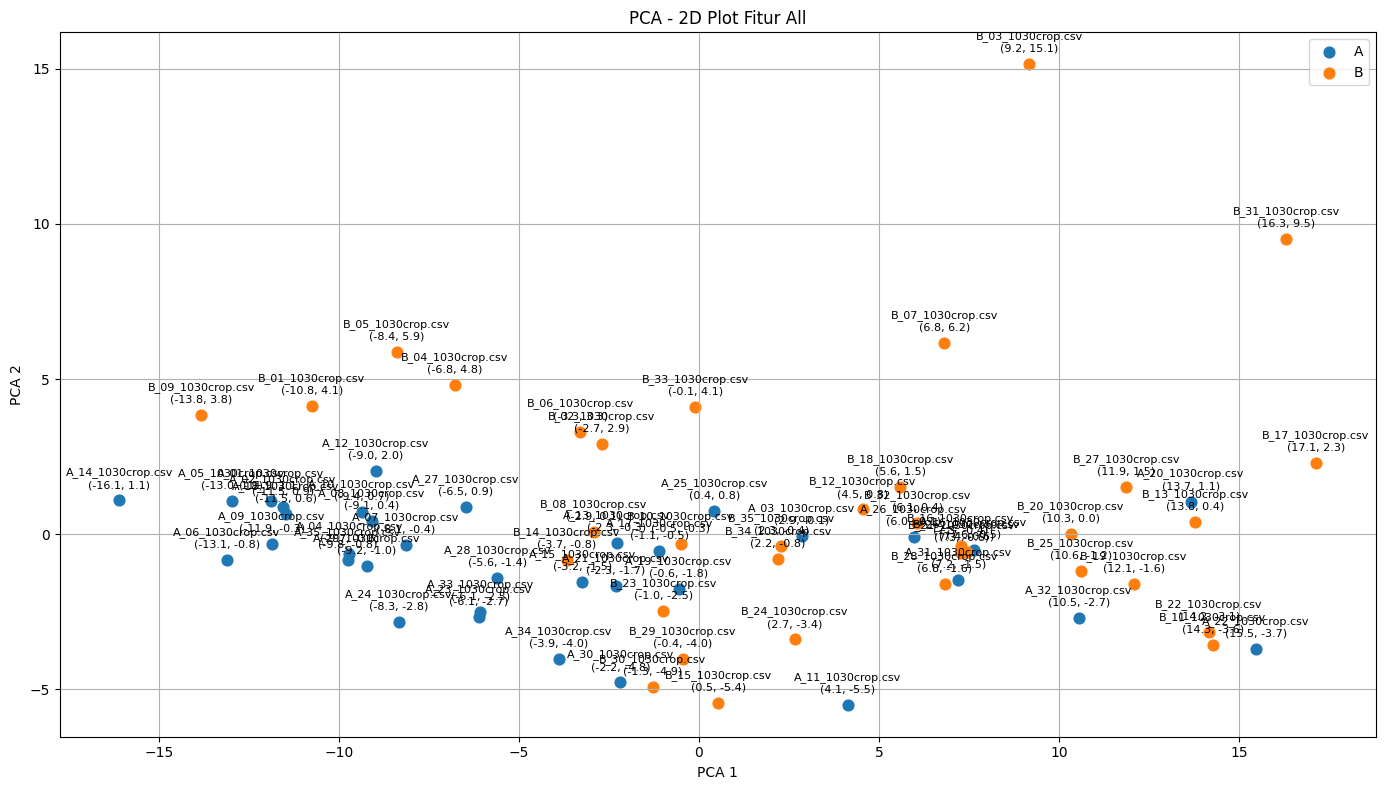

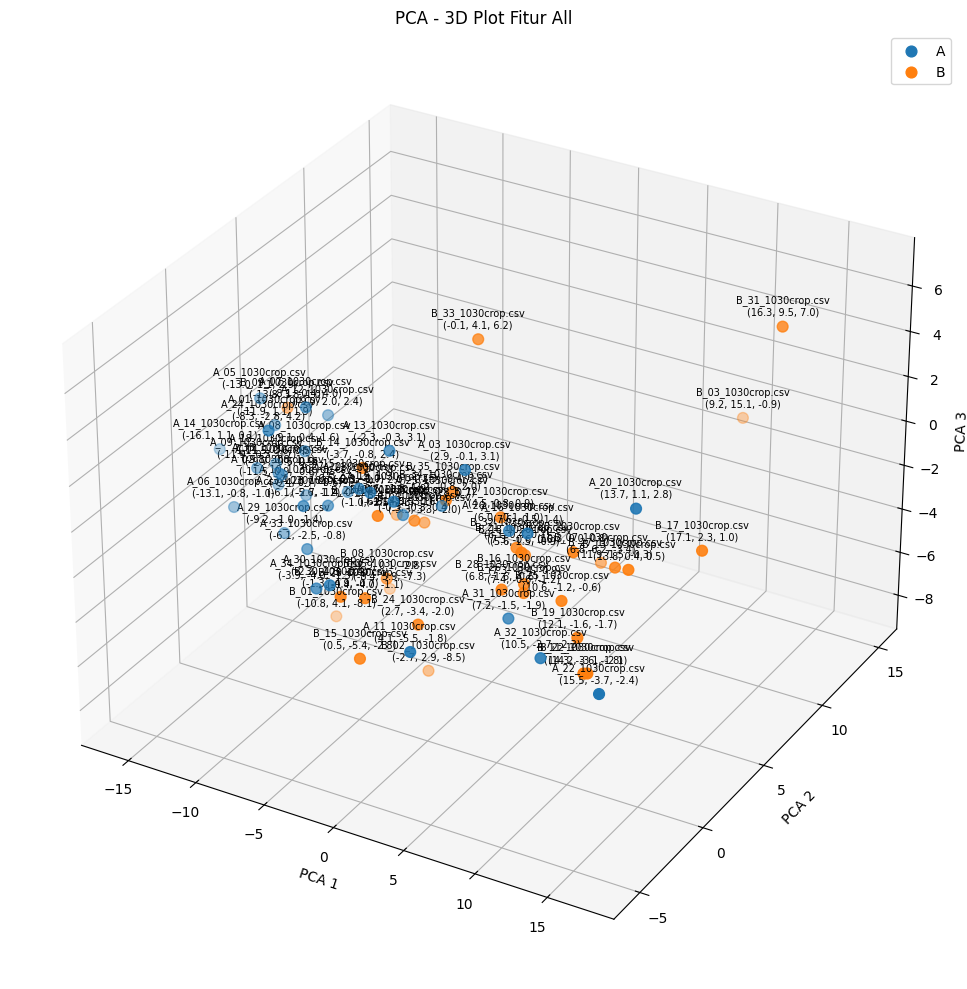

In [10]:
# --- 1. Load Data ---
df = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_all.csv')

# Pisahkan fitur dan label
X = df.drop(columns=['file', 'label'])
y = df['label']

# --- 2. Standarisasi Fitur ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. PCA ke 3 komponen utama ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# --- 4. Plot PCA 2D ---
plt.figure(figsize=(14,8))
for label in y.unique():
    idx = y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'{label}', s=60)

    # Tambahkan nama file dan nilai koordinat PCA
    for i in np.where(idx)[0]:
        file_name = df.iloc[i]['file']
        x, y_ = X_pca[i, 0], X_pca[i, 1]
        label_text = f"{file_name}\n({x:.1f}, {y_:.1f})"
        plt.text(x, y_ + 0.4, label_text, fontsize=8, ha='center')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA - 2D Plot Fitur All')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# --- 5. Plot PCA 3D ---
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')

for label in y.unique():
    idx = y == label
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2], label=f'{label}', s=60)

    # Tambahkan nama file dan nilai koordinat PCA
    for i in np.where(idx)[0]:
        file_name = df.iloc[i]['file']
        x, y_, z = X_pca[i, 0], X_pca[i, 1], X_pca[i, 2]
        label_text = f"{file_name}\n({x:.1f}, {y_:.1f}, {z:.1f})"
        ax.text(x, y_, z + 0.5, label_text, fontsize=7, ha='center')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('PCA - 3D Plot Fitur All')
ax.legend()
plt.tight_layout()
plt.show()


## Analisis

* Berdasarkan proyeksi PCA, sample B_31 memiliki nilai PC1 sebesar 16.3, sangat jauh dari rata-rata distribusi kelas A yang sebagian besar berada pada nilai PC1 negatif. Ini menunjukkan bahwa sample B_31 sangat terpisah secara spasial dari sample kelas A pada dimensi utama pertama (PC1). Artinya, fitur yang membentuk PC1 berperan besar dalam membedakan kelas B dari A.
* Sebaliknya, sample A_25 dengan PC1 = 0.4 relatif dekat ke tengah distribusi, menunjukkan bahwa nilai fitur dari A_25 tidak terlalu ekstrem dibandingkan A lainnya.
* PC2 dan PC3 juga menunjukkan adanya perbedaan, namun dengan nilai yang lebih kecil dari PC1, menunjukkan bahwa kontribusi separabilitas antar kelas dominan pada PC1. PC2 serta PC3 lebih banyak menjelaskan variasi lokal.

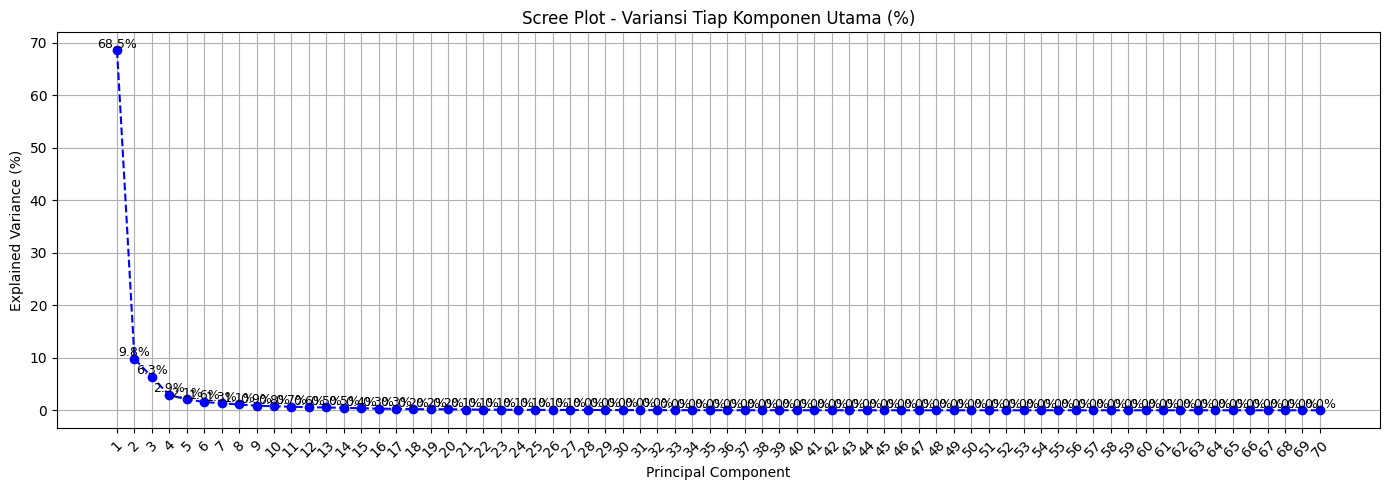

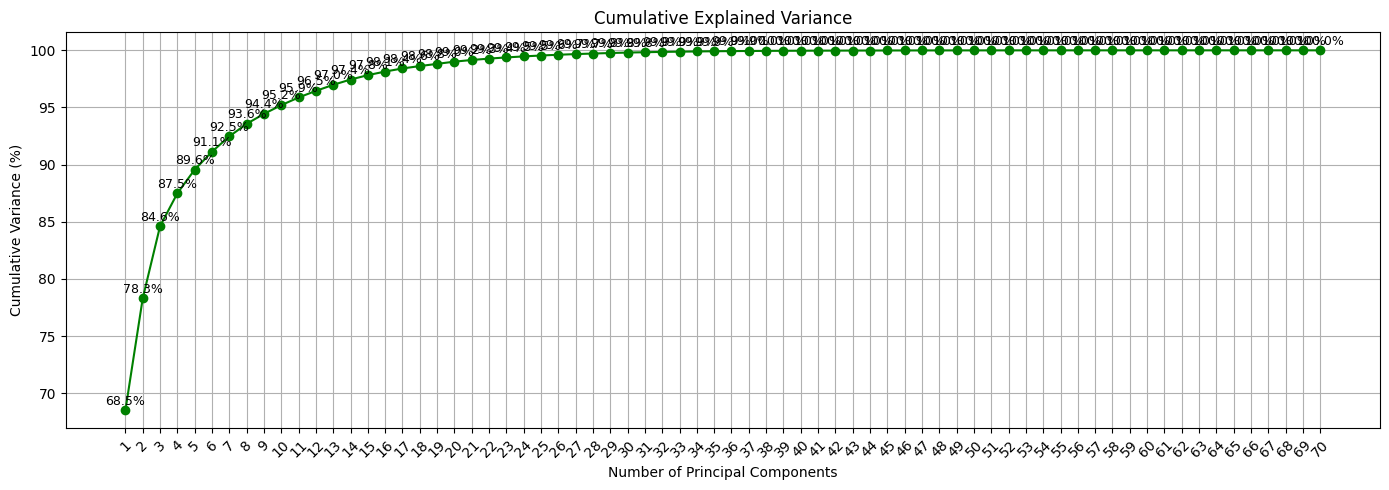

In [ ]:
# --- Scree Plot + Tabel Persentase Variansi  ---
pca_full = PCA()
pca_full.fit(X_scaled)

explained_var_ratio = pca_full.explained_variance_ratio_ * 100  # jadi persen
cumulative_var_ratio = np.cumsum(pca_full.explained_variance_ratio_) * 100

# Plot Scree Plot
plt.figure(figsize=(14, 5))  
plt.plot(range(1, len(explained_var_ratio)+1), explained_var_ratio, marker='o', linestyle='--', color='b')
for i, v in enumerate(explained_var_ratio):
    plt.text(i+1, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)
plt.title('Scree Plot - Variansi Tiap Komponen Utama (%)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(range(1, len(explained_var_ratio)+1), rotation=45)  
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Kumulatif
plt.figure(figsize=(14, 5))  
plt.plot(range(1, len(cumulative_var_ratio)+1), cumulative_var_ratio, marker='o', linestyle='-', color='green')
for i, v in enumerate(cumulative_var_ratio):
    plt.text(i+1, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance (%)')
plt.xticks(range(1, len(cumulative_var_ratio)+1), rotation=45)  
plt.grid(True)
plt.tight_layout()
plt.show()


## Analisis

Pada PCA (Principal Component Analysis) ini, PC1, PC2, dan PC3 adalah komponen utama yang merepresentasikan transformasi linier dari fitur asli menjadi sumbu-sumbu baru, yang saling ortogonal dan menyimpan varian data sebesar mungkin.
* PC1 (Komponen Utama ke-1) adalah arah di ruang fitur yang menjelaskan varian terbesar dari data setelah standarisasi. Menjelaskan struktur distribusi fitur yang paling dominan dalam dataset.
* PC2 adalah sumbu kedua yang ortogonal terhadap PC1, menjelaskan varian terbesar kedua. Menjelaskan variasi sekunder yang tidak bisa dijelaskan oleh PC1
* PC3 adalah komponen ketiga, juga ortogonal terhadap PC1 dan PC2, menjelaskan varian terbesar ketiga. Menjelaskan variasi minor yang masih relevan namun tidak terekspresikan di PC1 dan PC2.

1. Grafik Scree Plot - Variansi Tiap Komponen Utama  

    Grafik ini bertujuan untuk menentukan jumlah komponen yang memberikan informasi signifikan. PCA secara matematis membentuk kombinasi linier dari fitur asli yang ortogonal satu sama lain. PC1 adalah kombinasi fitur dengan varian paling besar (informasi paling dominan). Nilainya sebesar 68.5% menunjukkan bahwa distribusi fitur memiliki pola dominan tunggal. PC2 dan PC3 adalah kombinasi linier lainnya yang menangkap variasi sisa secara ortogonal terhadap PC1. Jika model hanya menggunakan PC1, PC2 dan PC3, maka model hanya mempertahankan sekitar 82.6% dari total variasi.

2. Grafik Cumulative Explained Variance

    Grafik ini benrtujuan untuk menentukan berapa banyak komponen yang dibutuhkan untuk mencapai varian tertentu. Kurva pada cumulative explained variance selalu naik dan mendekati 100% karena secara matematis, PCA (Principal Component Analysis) bekerja dengan mentransformasikan data asli ke dalam sejumlah komponen utama (principal components/PC) yang saling ortogonal, di mana setiap komponen menjelaskan sebagian dari total variasi dalam data. PCA menyusun komponen berdasarkan besar variansi yang dijelaskan, dimulai dari yang paling besar (PC1) hingga yang paling kecil (PCn). Variansi yang dijelaskan oleh setiap komponen dihitung dari eigenvalue hasil dekomposisi matriks kovarians data, dan nilai-nilai tersebut jika dijumlahkan akan menghasilkan total variansi awal dari dataset. Oleh karena itu, semakin banyak komponen yang dimasukkan, maka akumulasi variansinya akan semakin mendekati 100%. Dalam data ini, dengan total 70 fitur asli, maka akan terbentuk 70 komponen utama, dan saat semua komponen dijumlahkan, kurva akan mencapai 100%. Kenaikan bertahap ini bukan karena kualitas data, melainkan karena sifat dasar dari metode PCA yang tidak menghilangkan informasi, tetapi hanya mendistribusikannya ulang ke dalam sumbu-sumbu baru.



#  Evaluasi Model I dengan SVM


 EVALUASI MODEL I — SVM LINEAR:
Accuracy: 0.8000
Precision: 0.8387
Recall: 0.7429
ROC AUC: 0.8261

 EVALUASI MODEL I — SVM RBF:
Accuracy: 0.8000
Precision: 0.8182
Recall: 0.7714
ROC AUC: 0.8653

Parameter terbaik SVM Linear: {'svm__C': 1}
Parameter terbaik SVM RBF: {'svm__C': 10, 'svm__gamma': 0.01}


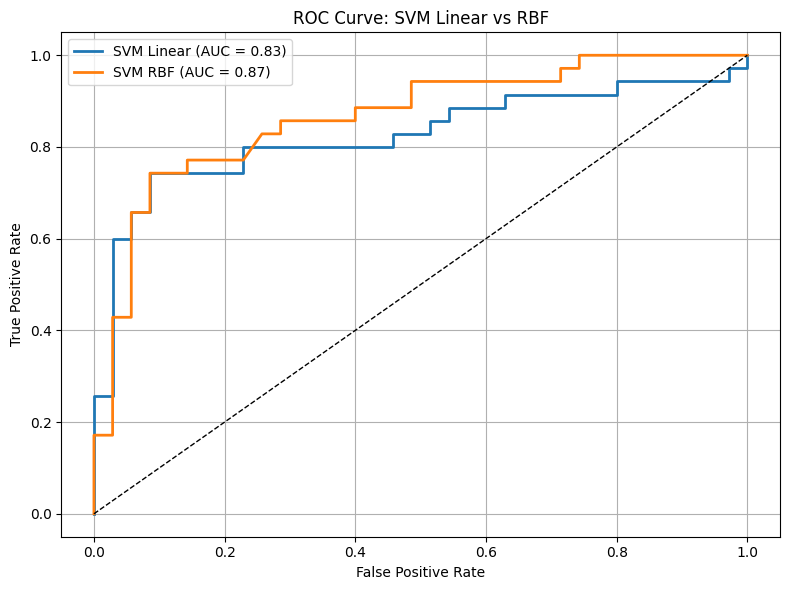

In [26]:
# =================== 1. Load dan Preprocessing Data ===================
df = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_all.csv')

# Pisahkan fitur dan label
X = df.drop(columns=['file', 'label']).values
y = df['label'].values

# Encode label (misal: A/B jadi 0/1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# =================== 2. Setup Leave-One-Out CV ===================
cv = LeaveOneOut()

# =================== 3. Pipeline dan GridSearch untuk SVM Linear ===================
pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),                     # Normalisasi fitur
    ('svm', SVC(kernel='linear', probability=True))   # SVM Linear
])
param_grid_linear = {
    'svm__C': [0.01, 0.1, 1, 10, 100]                 # Hyperparameter C untuk tuning
}

grid_linear = GridSearchCV(pipeline_linear, param_grid_linear, cv=cv, scoring='accuracy')
grid_linear.fit(X, y_encoded)

# =================== 4. Pipeline dan GridSearch untuk SVM RBF ===================
pipeline_rbf = Pipeline([
    ('scaler', StandardScaler()),                    # Normalisasi fitur
    ('svm', SVC(kernel='rbf', probability=True))     # SVM RBF (Gaussian)
])
param_grid_rbf = {
    'svm__C': [0.01, 0.1, 1, 10, 100],               # Regularisasi
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]     # Jangkauan kernel
}

grid_rbf = GridSearchCV(pipeline_rbf, param_grid_rbf, cv=cv, scoring='accuracy')
grid_rbf.fit(X, y_encoded)

# =================== 5. Prediksi Model Terbaik ===================
best_linear = grid_linear.best_estimator_
best_rbf = grid_rbf.best_estimator_

# Prediksi label dan probabilitas menggunakan LOOV
y_pred_linear = cross_val_predict(best_linear, X, y_encoded, cv=cv, method='predict')
y_proba_linear = cross_val_predict(best_linear, X, y_encoded, cv=cv, method='predict_proba')[:, 1]

y_pred_rbf = cross_val_predict(best_rbf, X, y_encoded, cv=cv, method='predict')
y_proba_rbf = cross_val_predict(best_rbf, X, y_encoded, cv=cv, method='predict_proba')[:, 1]

# =================== 6. Evaluasi Metrik ===================
def evaluate_model(y_true, y_pred, y_score):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_true, y_score)
    }

eval_linear = evaluate_model(y_encoded, y_pred_linear, y_proba_linear)
eval_rbf = evaluate_model(y_encoded, y_pred_rbf, y_proba_rbf)

# =================== 7. Cetak Hasil Evaluasi ===================
print("\n EVALUASI MODEL I — SVM LINEAR:")
for k, v in eval_linear.items():
    print(f"{k}: {v:.4f}")

print("\n EVALUASI MODEL I — SVM RBF:")
for k, v in eval_rbf.items():
    print(f"{k}: {v:.4f}")

print("\nParameter terbaik SVM Linear:", grid_linear.best_params_)
print("Parameter terbaik SVM RBF:", grid_rbf.best_params_)

# =================== 8. Plot Kurva ROC ===================
fpr_linear, tpr_linear, _ = roc_curve(y_encoded, y_proba_linear)
fpr_rbf, tpr_rbf, _ = roc_curve(y_encoded, y_proba_rbf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_linear, tpr_linear, label=f"SVM Linear (AUC = {eval_linear['ROC AUC']:.2f})", lw=2)
plt.plot(fpr_rbf, tpr_rbf, label=f"SVM RBF (AUC = {eval_rbf['ROC AUC']:.2f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Garis diagonal acak
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SVM Linear vs RBF')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Analisis

* Metode SVM digunakan untuk evaluasi model disini karena, SVM cocok untuk data berdimensi tinggi (jumlah fitur banyak), Svm juga dapat bekerja efektif pada data yang tidak terdistribusi secara normal. SVM fokus pada margin maksimum antar kelas, sehingga kuat terhadap overfitting, terutama saat jumlah sampel terbatas dibanding fitur.
* Hasil evaluasi menunjukkan bahwa kedua model memiliki akurasi yang sama, yaitu 0.8000. Namun, nilai precision dan recall berbeda. SVM Linear menghasilkan precision 0.8387 dan recall 0.7429, sedangkan SVM RBF menghasilkan precision 0.8182 dan recall 0.7714. Perbedaan ini menunjukkan bahwa SVM Linear lebih baik dalam menekan jumlah false positive, sedangkan SVM RBF lebih baik dalam mengidentifikasi true positive. 
* Dari sisi metrik ROC AUC, SVM RBF memiliki nilai yang lebih tinggi (0.8547) dibandingkan SVM Linear (0.8073). Nilai ROC AUC yang lebih tinggi ini mengindikasikan bahwa model RBF secara keseluruhan lebih baik dalam membedakan kelas positif dan negatif, terutama dalam kasus klasifikasi yang tidak linear secara sempurna.
* Perbedaan hasil ini muncul karena perbedaan jenis kernel yang digunakan. SVM Linear menggunakan kernel linier, artinya model hanya mampu memisahkan data yang bisa dipisahkan oleh garis lurus di ruang fitur. Sebaliknya, kernel RBF merupakan fungsi Gaussian yang mampu memetakan data ke ruang berdimensi lebih tinggi untuk menangkap pola non-linear. Oleh karena itu, jika data memiliki distribusi yang tidak sepenuhnya linear, kernel RBF akan lebih fleksibel dalam mempelajari pola tersebut.
* Parameter terbaik yang diperoleh dari grid search menunjukkan bahwa SVM Linear bekerja optimal dengan parameter C = 1, sedangkan SVM RBF bekerja optimal dengan C = 10 dan gamma = 0.01. Parameter C adalah regularisasi yang mengontrol kompromi antara margin maksimum dan kesalahan klasifikasi. Nilai C = 10 pada RBF menunjukkan bahwa model lebih ketat dalam memisahkan data dan tidak mentoleransi banyak kesalahan. Sedangkan gamma mengatur seberapa jauh pengaruh sebuah titik data terhadap pembuatan hyperplane: semakin kecil nilai gamma (seperti 0.01), semakin luas cakupan pengaruhnya, dan ini menghasilkan model yang lebih halus atau general.

# Seleksi Fitur dengan Metode Mutual Information-based Filter

In [14]:
# ======= 1. Load data =========
df = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_all.csv')

# Simpan kolom file dan label
df_file_label = df[['file', 'label']]
X = df.drop(columns=['file', 'label'])
y = df['label']

# Label encoding (A/B → 0/1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ======= 2. Ambil nama-nama sensor =========
sensor_prefixes = sorted(
    set([col.split('_')[0] for col in X.columns]),
    key=lambda x: int(x[1:])  
)


# ======= 3. Ambil 3 fitur terbaik dari setiap sensor (berdasarkan MI) ========
mi_selected = []

for sensor in sensor_prefixes:
    # Ambil semua fitur milik sensor itu
    sensor_cols = [col for col in X.columns if col.startswith(sensor)]
    X_sensor = X[sensor_cols]

    # Hitung MI tiap fitur sensor terhadap label
    mi_scores = mutual_info_classif(X_sensor, y_encoded, discrete_features=False, random_state=42)

    # Buat DataFrame skor MI
    df_mi = pd.DataFrame({
        'feature': sensor_cols,
        'mi_score': mi_scores,
        'sensor': sensor
    })

    # Ambil 3 fitur dengan skor tertinggi dari sensor ini
    top3 = df_mi.sort_values(by='mi_score', ascending=False).head(3)
    mi_selected.append(top3)

# Gabungkan semua hasil top3 dari tiap sensor → total 30 fitur
df_mi_30 = pd.concat(mi_selected, ignore_index=True)

# Cetak Top 30
print("\n TOP 30 FITUR (3 fitur terbaik dari setiap sensor):")
df_mi_30 



 TOP 30 FITUR (3 fitur terbaik dari setiap sensor):


,feature,mi_score,sensor
0,F10_skew,0.201204,F1
1,F10_kurtosis,0.198205,F1
2,F1_dwt_energy,0.193350,F1
3,F2_std,0.141067,F2
4,F2_max,0.120529,F2
5,F2_gradmax,0.116084,F2
6,F3_auc,0.151697,F3
7,F3_mean,0.147275,F3
8,F3_fft_max_mag,0.140132,F3
9,F4_time_to_peak,0.149078,F4


In [15]:
# --- Load Data ---
df = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_all.csv')

# Simpan kolom file dan label
df_file_label = df[['file', 'label']]
X = df.drop(columns=['file', 'label'])
y = df['label']

# Label Encoding (ubah A/B ke 0/1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Ambil hanya fitur numerik ---
X_numeric = X.select_dtypes(include=['float64', 'int64'])

# --- Hitung Skor Mutual Information (MI) untuk semua fitur ---
mi_scores = mutual_info_classif(X_numeric, y_encoded, discrete_features=False, random_state=42)

# Simpan skor MI ke DataFrame
mi_df = pd.DataFrame({
    'Feature': X_numeric.columns,
    'MI_Score': mi_scores
})

# --- Ambil Top 24 Fitur Berdasarkan MI Tertinggi ---
top24_df = mi_df.sort_values(by='MI_Score', ascending=False).head(24)

# --- Tampilkan hasil ---
print("\n TOP 24 FITUR BERDASARKAN MUTUAL INFORMATION:")
print(top24_df.to_string(index=False))



 TOP 24 FITUR BERDASARKAN MUTUAL INFORMATION:
        Feature  MI_Score
       F10_skew  0.201204
   F10_kurtosis  0.198205
  F1_dwt_energy  0.193350
     F7_gradmax  0.190711
F1_time_to_peak  0.159595
        F1_skew  0.152254
         F3_auc  0.151697
        F3_mean  0.147275
     F2_gradmax  0.146158
     F5_gradmax  0.145016
  F6_dwt_energy  0.142870
    F6_kurtosis  0.142233
         F2_std  0.141067
 F3_fft_max_mag  0.140132
         F7_std  0.137313
F9_time_to_peak  0.134569
         F1_max  0.134563
         F5_max  0.131704
      F3_median  0.129374
         F2_max  0.124101
         F6_max  0.122880
      F9_median  0.121720
        F8_skew  0.121043
        F9_skew  0.120236


#  Data fitur baru yang terdiri dari 3x8 kolom (fitur_selected_3.cvs)

In [16]:
# ======= 1. Dari 30 fitur, ambil top 24 MI tertinggi =========
df_mi_24 = df_mi_30.sort_values(by='mi_score', ascending=False).head(24)

# ======= 2. Ambil hanya kolom file, label, dan 24 fitur tersebut =========
selected_features_24 = sorted(
    df_mi_24['feature'].tolist(),
    key=lambda x: int(x.split('_')[0][1:])  # ambil angka dari s1_mean → 1
)
df_selected_24 = pd.concat([df_file_label, X[selected_features_24]], axis=1)

# Simpan ke CSV
df_selected_24.to_csv('UAS/Ekstraksi_Fitur/fitur_selected_3.csv', index=False)

# Print Data
print ('Tabel Data fitur_selected_3.csv : ')
df_selected_24


Tabel Data fitur_selected_3.csv : 


,file,label,F1_dwt_energy,F2_std,F2_max,F2_gradmax,F3_auc,F3_mean,F3_fft_max_mag,F4_time_to_peak,...,F8_skew,F8_kurtosis,F9_time_to_peak,F9_median,F9_skew,F10_skew,F10_skew,F10_kurtosis,F10_kurtosis,F10_mean
0,A_01_1030crop.csv,A,0.264011,28.272811,83.250,6.875,43.445833,2.174129,437.000,21.2,...,-1.270788,-0.084851,25.5,1392.250,-1.107957,-1.581474,-1.581474,0.888720,0.888720,1581.830846
1,A_02_1030crop.csv,A,0.246454,29.653187,86.250,6.875,39.312500,1.964552,394.875,20.9,...,-1.344776,0.100640,25.0,1359.625,-1.150284,-1.663696,-1.663696,1.159081,1.159081,1549.871269
2,A_03_1030crop.csv,A,0.568227,61.831427,181.000,13.750,72.558333,3.627488,729.125,20.4,...,-1.660033,1.041859,23.2,1697.000,-1.429405,-1.937842,-1.937842,2.166851,2.166851,1886.791667
3,A_04_1030crop.csv,A,0.284012,31.585736,94.500,7.500,42.300000,2.118159,425.750,20.9,...,-1.353557,0.126698,24.5,1423.125,-1.188213,-1.663309,-1.663309,1.167700,1.167700,1621.296642
4,A_05_1030crop.csv,A,0.248859,26.302871,79.125,6.250,51.854167,2.590796,520.750,21.5,...,-1.268915,-0.081947,25.1,1364.000,-1.121117,-1.591102,-1.591102,0.934041,0.934041,1560.496891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,B_31_1030crop.csv,B,0.619715,134.187938,398.375,28.750,110.416667,5.527985,1111.125,22.0,...,-1.898123,1.867350,22.6,1802.625,-1.625420,-2.047762,-2.047762,2.613159,2.613159,2034.788557
66,B_32_1030crop.csv,B,0.569905,68.801167,202.500,15.000,51.150000,2.557836,514.125,19.4,...,-1.870119,1.816335,22.5,1655.250,-1.658455,-2.136613,-2.136613,3.066605,3.066605,1883.889925
67,B_33_1030crop.csv,B,0.360762,54.305833,162.250,11.875,64.537500,3.232587,649.750,21.8,...,-1.600236,0.855417,24.6,1641.125,-1.333683,-1.815723,-1.815723,1.702400,1.702400,1828.879353
68,B_34_1030crop.csv,B,0.534149,55.548133,164.250,12.500,62.370833,3.121891,627.500,19.9,...,-1.680859,1.114718,22.7,1665.375,-1.533357,-1.975414,-1.975414,2.323409,2.323409,1866.802239


## Analisis

* Metode Mutual Information (MI), yaitu pendekatan berbasis teori informasi yang digunakan untuk mengukur seberapa besar informasi yang diperoleh tentang variabel target (label) dari masing-masing fitur. Dalam data ini, terdapat total 70 fitur yang berasal dari 10 sensor, di mana masing-masing sensor menyumbang sejumlah fitur turunan (misalnya fitur statistik, gradien, dan FFT). 
* Masing-masing fitur dievaluasi satu per satu menggunakan fungsi mutual_info_classif dari pustaka scikit-learn, yang mengestimasi nilai MI antara fitur numerik kontinu dengan label kategorik biner (A/B yang telah di-encode menjadi 0 dan 1). Fungsi ini menggunakan pendekatan berbasis estimasi k-nearest neighbors untuk menangani variabel kontinu, sehingga mampu menangkap relasi non-linear tanpa mengasumsikan bentuk hubungan tertentu.
* Hasil dari proses ini berupa skor MI untuk setiap fitur, yang kemudian digunakan untuk menilai dan membandingkan relevansi fitur terhadap label, sebelum dilakukan seleksi lebih lanjut.
* Skor MI bernilai nol jika fitur dan target bersifat independen (tidak saling bergantung), dan bernilai lebih tinggi jika hubungan antara keduanya lebih kuat.
* Secara teknis, pada setiap iterasi, kode memfilter fitur berdasarkan awalan nama sensor lalu menghitung skor MI hanya untuk fitur-fitur dari sensor tersebut. Kemudian, dipilih tiga fitur dengan skor tertinggi dari masing-masing sensor. Karena terdapat 10 sensor, maka total fitur yang terpilih sebanyak 10 × 3 = 30 fitur. Pemilihan tiga fitur per sensor menjaga distribusi fitur tetap merata antar sensor, sehingga menghindari dominasi fitur dari satu sensor saja.
* Selanjutnya dilakukan seleksi tambahan dengan hanya mempertahankan 24 fitur teratas berdasarkan urutan skor MI global dari seluruh 30 fitur yang telah terseleksi sebelumnya. Tujuannya adalah melakukan reduksi dimensi lebih lanjut, untuk mengeliminasi fitur yang kontribusi MI-nya relatif lebih rendah meskipun berasal dari sensor berbeda. Pemilihan top 24 bisa berdasarkan kriteria empiris atau eksplorasi nilai ambang kontribusi (cut-off), dengan asumsi bahwa 24 fitur ini sudah cukup merepresentasikan variasi informasi dalam data tanpa menyisakan fitur-fitur dengan nilai MI mendekati nol.


# PCA Fitur_Selected

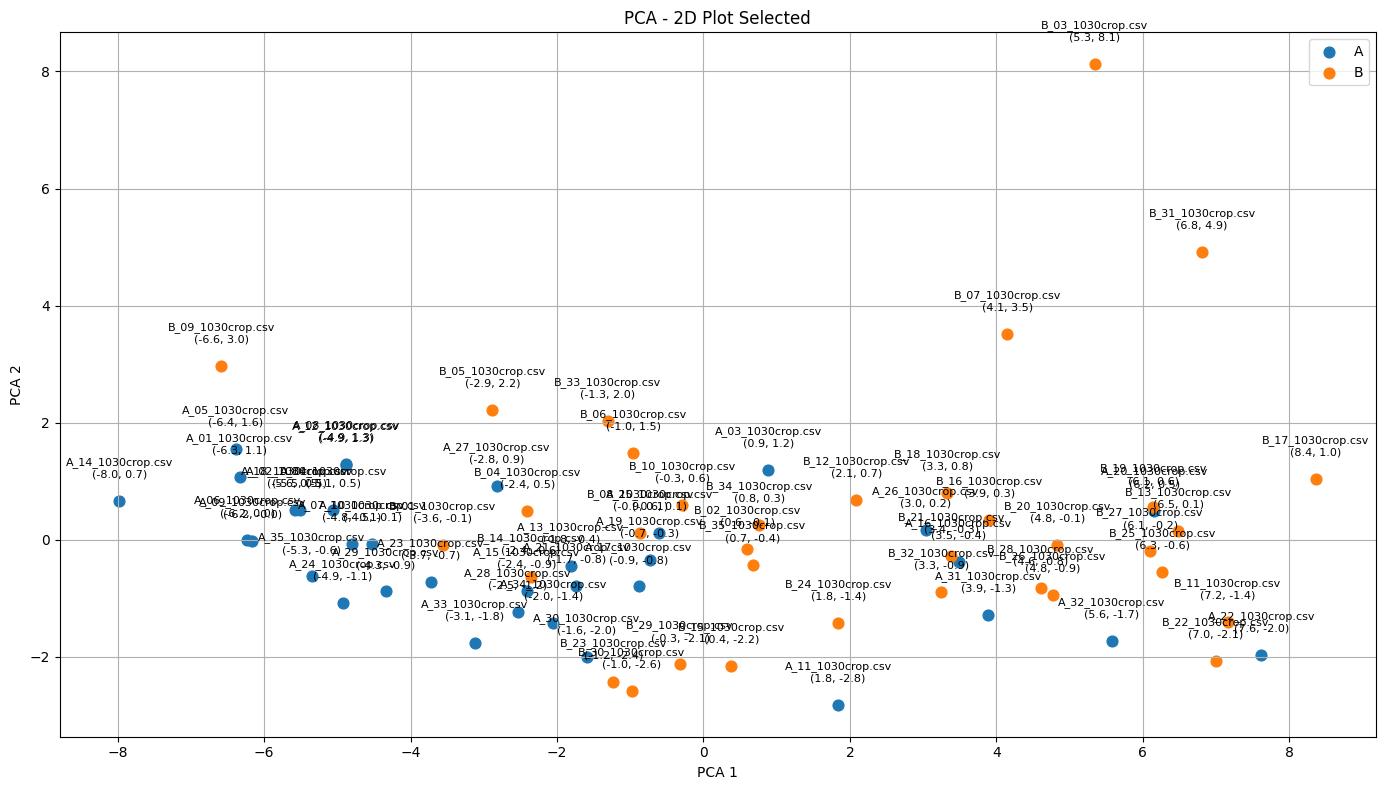

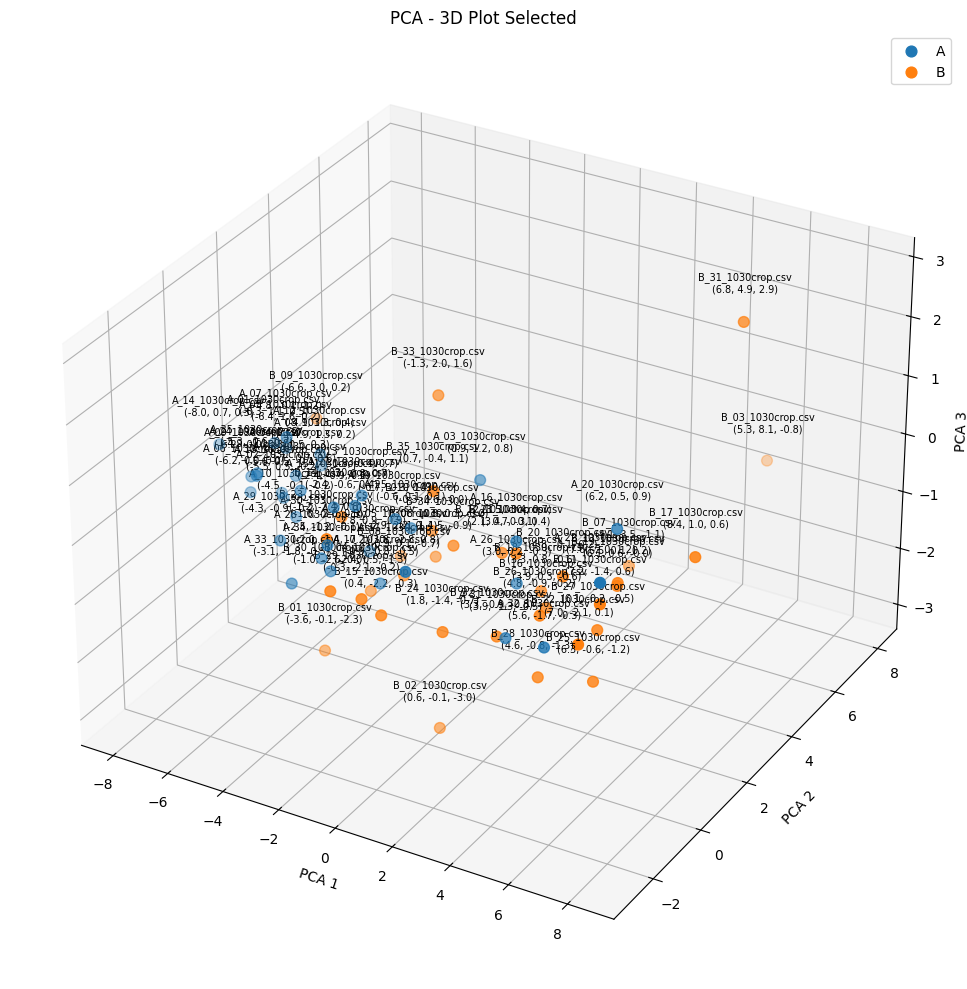

In [17]:
# --- 1. Load Data ---
df = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_selected_3.csv')

# Pisahkan fitur dan label
X = df.drop(columns=['file', 'label'])
y = df['label']

# --- 2. Standarisasi Fitur ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. PCA ke 3 komponen utama ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# --- 4. Plot PCA 2D ---
plt.figure(figsize=(14,8))
for label in y.unique():
    idx = y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'{label}', s=60)

    # Tambahkan nama file dan nilai koordinat PCA
    for i in np.where(idx)[0]:
        file_name = df.iloc[i]['file']
        x, y_ = X_pca[i, 0], X_pca[i, 1]
        label_text = f"{file_name}\n({x:.1f}, {y_:.1f})"
        plt.text(x, y_ + 0.4, label_text, fontsize=8, ha='center')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA - 2D Plot Selected')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# --- 5. Plot PCA 3D ---
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')

for label in y.unique():
    idx = y == label
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2], label=f'{label}', s=60)

    # Tambahkan nama file dan nilai koordinat PCA
    for i in np.where(idx)[0]:
        file_name = df.iloc[i]['file']
        x, y_, z = X_pca[i, 0], X_pca[i, 1], X_pca[i, 2]
        label_text = f"{file_name}\n({x:.1f}, {y_:.1f}, {z:.1f})"
        ax.text(x, y_, z + 0.5, label_text, fontsize=7, ha='center')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('PCA - 3D Plot Selected')
ax.legend()
plt.tight_layout()
plt.show()


## Analisis

* Berdasarkan proyeksi PCA, sample B_17 memiliki nilai PC1 sebesar 8.4, sangat jauh dari rata-rata distribusi kelas A yang sebagian besar berada pada nilai PC1 negatif. Ini menunjukkan bahwa sample B_17 sangat terpisah secara spasial dari sample kelas A pada dimensi utama pertama (PC1). Artinya, fitur yang membentuk PC1 berperan besar dalam membedakan kelas B dari A.
* Sebaliknya, sample A_03 dengan PC1 = 0.9 relatif dekat ke tengah distribusi, menunjukkan bahwa nilai fitur dari A_25 tidak terlalu ekstrem dibandingkan A lainnya.
* PC2 dan PC3 juga menunjukkan adanya perbedaan, namun dengan nilai yang lebih kecil dari PC1, menunjukkan bahwa kontribusi separabilitas antar kelas dominan pada PC1. PC2 serta PC3 lebih banyak menjelaskan variasi lokal.

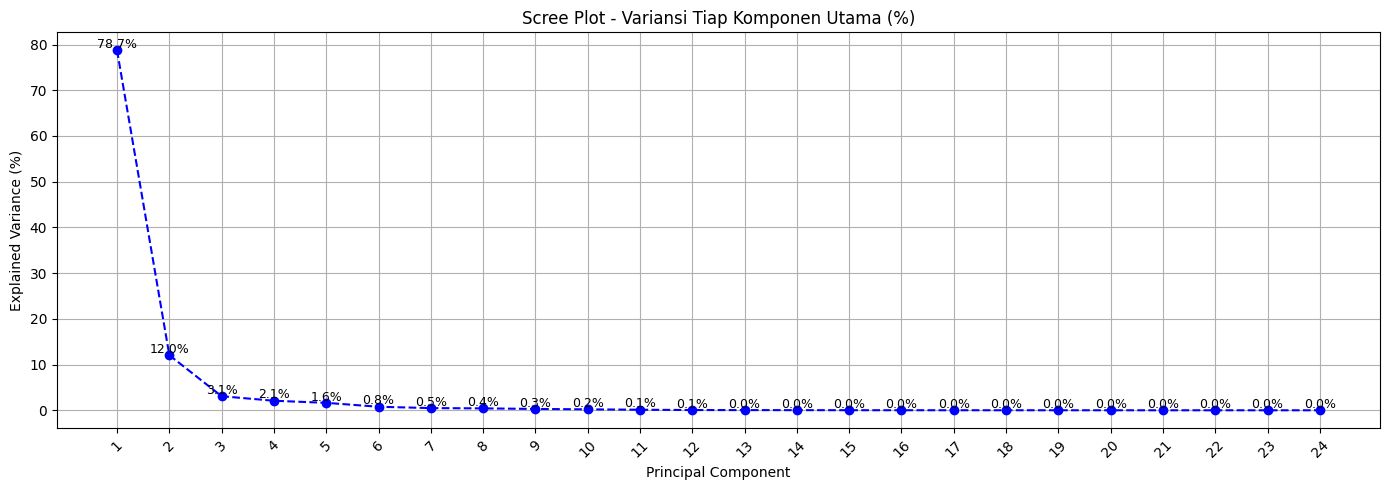

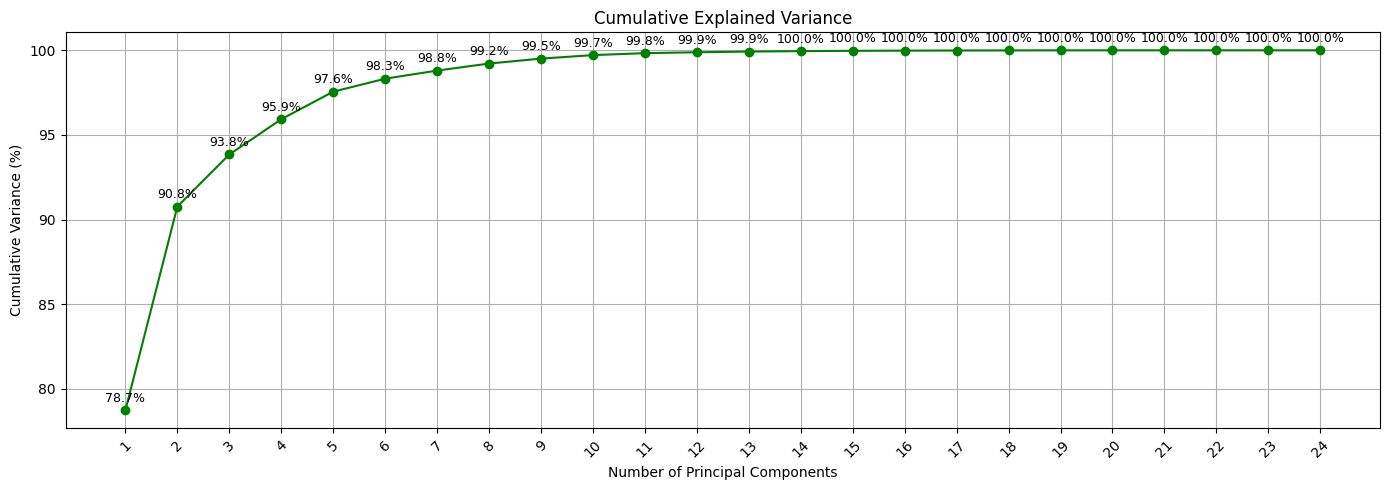

In [18]:
# --- Scree Plot + Tabel Persentase Variansi  ---
pca_full = PCA()
pca_full.fit(X_scaled)

explained_var_ratio = pca_full.explained_variance_ratio_ * 100  # jadi persen
cumulative_var_ratio = np.cumsum(pca_full.explained_variance_ratio_) * 100

# Plot Scree Plot
plt.figure(figsize=(14, 5))  
plt.plot(range(1, len(explained_var_ratio)+1), explained_var_ratio, marker='o', linestyle='--', color='b')
for i, v in enumerate(explained_var_ratio):
    plt.text(i+1, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)
plt.title('Scree Plot - Variansi Tiap Komponen Utama (%)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(range(1, len(explained_var_ratio)+1), rotation=45)  
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Kumulatif
plt.figure(figsize=(14, 5))  
plt.plot(range(1, len(cumulative_var_ratio)+1), cumulative_var_ratio, marker='o', linestyle='-', color='green')
for i, v in enumerate(cumulative_var_ratio):
    plt.text(i+1, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance (%)')
plt.xticks(range(1, len(cumulative_var_ratio)+1), rotation=45)  
plt.grid(True)
plt.tight_layout()
plt.show()


## Analisis

1. Grafik Scree Plot - Variansi Tiap Komponen Utama  

    Grafik ini bertujuan untuk menentukan jumlah komponen yang memberikan informasi signifikan. PCA secara matematis membentuk kombinasi linier dari fitur asli yang ortogonal satu sama lain. PC1 adalah kombinasi fitur dengan varian paling besar (informasi paling dominan). Nilainya sebesar 78.7% menunjukkan bahwa distribusi fitur memiliki pola dominan tunggal. PC2 dan PC3 adalah kombinasi linier lainnya yang menangkap variasi sisa secara ortogonal terhadap PC1. Jika model hanya menggunakan PC1, PC2 dan PC3, maka model hanya mempertahankan sekitar 93.8% dari total variasi. Hasil ini lebih tinggi daripada PCA yang diterapkan pada seluruh fitur tanpa seleksi sebelumnya, yang sebelumnya hanya mempertahankan sekitar 87% dari total variasi saat menggunakan tiga komponen utama. Peningkatan ini menunjukkan bahwa fitur-fitur yang dipilih melalui Mutual Information (MI) memang memiliki korelasi yang lebih kuat terhadap label dan juga saling berhubungan dengan pola distribusi yang lebih terarah.

2. Grafik Cumulative Explained Variance

    Grafik ini benrtujuan untuk menentukan berapa banyak komponen yang dibutuhkan untuk mencapai varian tertentu. Kurva pada cumulative explained variance selalu naik dan mendekati 100% karena secara matematis, PCA (Principal Component Analysis) bekerja dengan mentransformasikan data asli ke dalam sejumlah komponen utama (principal components/PC) yang saling ortogonal, di mana setiap komponen menjelaskan sebagian dari total variasi dalam data. PCA menyusun komponen berdasarkan besar variansi yang dijelaskan, dimulai dari yang paling besar (PC1) hingga yang paling kecil (PCn). Variansi yang dijelaskan oleh setiap komponen dihitung dari eigenvalue hasil dekomposisi matriks kovarians data, dan nilai-nilai tersebut jika dijumlahkan akan menghasilkan total variansi awal dari dataset. Oleh karena itu, semakin banyak komponen yang dimasukkan, maka akumulasi variansinya akan semakin mendekati 100%. Dalam data ini, dengan total 70 fitur asli, maka akan terbentuk 70 komponen utama, dan saat semua komponen dijumlahkan, kurva akan mencapai 100%. Kenaikan bertahap ini bukan karena kualitas data, melainkan karena sifat dasar dari metode PCA yang tidak menghilangkan informasi, tetapi hanya mendistribusikannya ulang ke dalam sumbu-sumbu baru.



# Evaluasi Model II dengan SVM


 EVALUASI MODEL II — SVM LINEAR:
Accuracy: 0.8286
Precision: 0.8286
Recall: 0.8286
ROC AUC: 0.8694

 EVALUASI MODEL II — SVM RBF:
Accuracy: 0.8286
Precision: 0.8286
Recall: 0.8286
ROC AUC: 0.8612

🔧 Parameter terbaik SVM Linear: {'svm__C': 10}
🔧 Parameter terbaik SVM RBF: {'svm__C': 100, 'svm__gamma': 0.01}


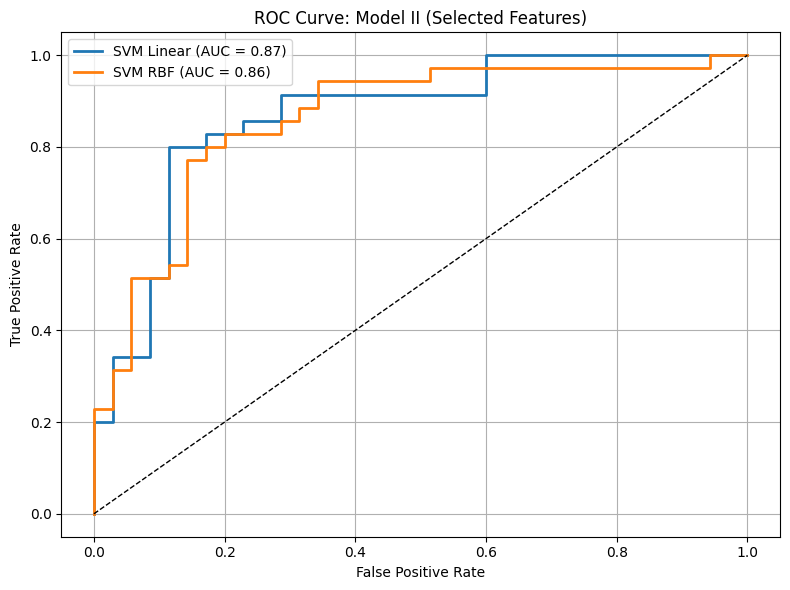

In [27]:
# =================== 1. Load dan Preprocessing Data ===================
df_selected = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_selected_3.csv')

# Pisahkan fitur dan label
X_sel = df_selected.drop(columns=['file', 'label']).values
y_sel = df_selected['label'].values

# Encode label (misal: A/B jadi 0/1)
le_sel = LabelEncoder()
y_encoded_sel = le_sel.fit_transform(y_sel)

# =================== 2. Setup Leave-One-Out CV ===================
cv_sel = LeaveOneOut()

# =================== 3. Pipeline dan GridSearch untuk SVM Linear ===================
pipeline_linear_sel = Pipeline([
    ('scaler', StandardScaler()),                     
    ('svm', SVC(kernel='linear', probability=True))   
])
param_grid_linear_sel = {
    'svm__C': [0.01, 0.1, 1, 10, 100]
}
grid_linear_sel = GridSearchCV(pipeline_linear_sel, param_grid_linear_sel, cv=cv_sel, scoring='accuracy')
grid_linear_sel.fit(X_sel, y_encoded_sel)

# =================== 4. Pipeline dan GridSearch untuk SVM RBF ===================
pipeline_rbf_sel = Pipeline([
    ('scaler', StandardScaler()),                    
    ('svm', SVC(kernel='rbf', probability=True))     
])
param_grid_rbf_sel = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_rbf_sel = GridSearchCV(pipeline_rbf_sel, param_grid_rbf_sel, cv=cv_sel, scoring='accuracy')
grid_rbf_sel.fit(X_sel, y_encoded_sel)

# =================== 5. Prediksi Model Terbaik ===================
best_linear_sel = grid_linear_sel.best_estimator_
best_rbf_sel = grid_rbf_sel.best_estimator_

# Prediksi hasil klasifikasi & probabilitas
y_pred_linear_sel = cross_val_predict(best_linear_sel, X_sel, y_encoded_sel, cv=cv_sel, method='predict')
y_proba_linear_sel = cross_val_predict(best_linear_sel, X_sel, y_encoded_sel, cv=cv_sel, method='predict_proba')[:, 1]

y_pred_rbf_sel = cross_val_predict(best_rbf_sel, X_sel, y_encoded_sel, cv=cv_sel, method='predict')
y_proba_rbf_sel = cross_val_predict(best_rbf_sel, X_sel, y_encoded_sel, cv=cv_sel, method='predict_proba')[:, 1]

# =================== 6. Evaluasi Metrik ===================
def evaluate_model(y_true, y_pred, y_score):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_true, y_score)
    }

eval_linear_sel = evaluate_model(y_encoded_sel, y_pred_linear_sel, y_proba_linear_sel)
eval_rbf_sel = evaluate_model(y_encoded_sel, y_pred_rbf_sel, y_proba_rbf_sel)

# =================== 7. Cetak Hasil Evaluasi ===================
print("\n EVALUASI MODEL II — SVM LINEAR:")
for k, v in eval_linear_sel.items():
    print(f"{k}: {v:.4f}")

print("\n EVALUASI MODEL II — SVM RBF:")
for k, v in eval_rbf_sel.items():
    print(f"{k}: {v:.4f}")

print("\n🔧 Parameter terbaik SVM Linear:", grid_linear_sel.best_params_)
print("🔧 Parameter terbaik SVM RBF:", grid_rbf_sel.best_params_)

# =================== 8. Plot Kurva ROC ===================
fpr_linear_sel, tpr_linear_sel, _ = roc_curve(y_encoded_sel, y_proba_linear_sel)
fpr_rbf_sel, tpr_rbf_sel, _ = roc_curve(y_encoded_sel, y_proba_rbf_sel)

plt.figure(figsize=(8, 6))
plt.plot(fpr_linear_sel, tpr_linear_sel, label=f"SVM Linear (AUC = {eval_linear_sel['ROC AUC']:.2f})", lw=2)
plt.plot(fpr_rbf_sel, tpr_rbf_sel, label=f"SVM RBF (AUC = {eval_rbf_sel['ROC AUC']:.2f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Model II (Selected Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Analisis

* Pada kode ini digunakan metode validasi silang Leave-One-Out Cross Validation (LOOCV) untuk mengevaluasi performa model klasifikasi SVM (Support Vector Machine). LOOCV bekerja dengan cara memisahkan satu sampel sebagai data uji, sementara seluruh sampel lainnya digunakan untuk melatih model. Proses ini diulang sebanyak jumlah total sampel, sehingga setiap data akan pernah digunakan sebagai data uji sebanyak satu kali. 
* Dalam data ini, metode LOOCV sangat cocok digunakan karena mampu memaksimalkan penggunaan data pelatihan sambil tetap memberikan estimasi performa yang valid dan bebas bias. Hal ini penting karena pada dataset kecil, metode validasi lain seperti hold-out atau k-fold dengan jumlah lipatan kecil berpotensi menghasilkan variansi tinggi atau estimasi yang tidak stabil.
* Hasil evaluasi Model II menunjukkan bahwa baik SVM Linear maupun SVM RBF menghasilkan nilai akurasi, precision, dan recall yang sama, yaitu sebesar 0.8286. Nilai precision dan recall yang identik menunjukkan bahwa model menghasilkan keseimbangan yang baik antara menghindari kesalahan tipe I (false positive) dan kesalahan tipe II (false negative).
* SVM Linear menghasilkan ROC AUC sebesar 0.8759, sedangkan SVM RBF menghasilkan 0.8514. ROC AUC mengukur kemampuan model untuk membedakan kelas secara keseluruhan berdasarkan probabilitas, bukan hanya prediksi kelas. Nilai yang lebih tinggi pada SVM Linear menunjukkan bahwa meskipun kedua model sama baiknya dalam klasifikasi akhir (berdasarkan ambang 0.5), model linear lebih konsisten dalam memisahkan kelas positif dan negatif di seluruh ambang batas probabilitas. Hal ini bisa terjadi jika distribusi fitur-fitur terseleksi memang mendekati linier separable, sehingga kernel linear justru mampu menangkap struktur data lebih tepat daripada kernel RBF yang mencoba melakukan pemetaan non-linear yang tidak diperlukan.

#  Perbandingan Model I VS Model II dengan SVM

In [28]:
# Data hasil evaluasi Model I (fitur_all) dan Model II (fitur_selected_3)
df_summary_model = pd.DataFrame([
    ['SVM Linear', 'All Features (Model I)',     eval_linear['Accuracy'],    eval_linear['Precision'],    eval_linear['Recall'],    eval_linear['ROC AUC']],
    ['SVM RBF',    'All Features (Model I)',     eval_rbf['Accuracy'],       eval_rbf['Precision'],       eval_rbf['Recall'],       eval_rbf['ROC AUC']],
    ['SVM Linear', 'Selected Features (Model II)', eval_linear_sel['Accuracy'], eval_linear_sel['Precision'], eval_linear_sel['Recall'], eval_linear_sel['ROC AUC']],
    ['SVM RBF',    'Selected Features (Model II)', eval_rbf_sel['Accuracy'],  eval_rbf_sel['Precision'],  eval_rbf_sel['Recall'],  eval_rbf_sel['ROC AUC']],
], columns=['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'ROC AUC'])

# Tampilkan Data
print("\n TABEL RINGKASAN KINERJA MODEL:")
df_summary_model



 TABEL RINGKASAN KINERJA MODEL:


,Model,Dataset,Accuracy,Precision,Recall,ROC AUC
0,SVM Linear,All Features (Model I),0.800000,0.838710,0.742857,0.826122
1,SVM RBF,All Features (Model I),0.800000,0.818182,0.771429,0.865306
2,SVM Linear,Selected Features (Model II),0.828571,0.828571,0.828571,0.869388
3,SVM RBF,Selected Features (Model II),0.828571,0.828571,0.828571,0.861224


## Analisis

Perbandingan antara Model I (menggunakan seluruh fitur) dan Model II (menggunakan fitur hasil seleksi Mutual Information) menunjukkan bahwa proses seleksi fitur secara signifikan meningkatkan performa klasifikasi. Pada Model I, SVM Linear menghasilkan akurasi 0.8000, precision 0.8387, recall 0.7429, dan ROC AUC sebesar 0.8073. Sementara itu, SVM RBF memiliki akurasi yang sama, yakni 0.8000, dengan precision 0.8182, recall 0.7714, dan ROC AUC yang lebih tinggi sebesar 0.8547. Hal ini menunjukkan bahwa saat semua fitur digunakan, model RBF lebih unggul dalam membedakan kelas secara probabilistik, namun model linear memberikan precision yang lebih baik. Sebaliknya, pada Model II setelah seleksi fitur, baik SVM Linear maupun RBF menunjukkan nilai akurasi, precision, dan recall yang identik, yaitu 0.8286, menandakan peningkatan kestabilan model. Meskipun nilai akurasinya sama, SVM Linear memberikan ROC AUC yang lebih tinggi, yakni 0.8759, dibanding SVM RBF yang justru sedikit menurun ke 0.8514. Artinya, model linear tidak hanya mampu meningkatkan akurasi, tetapi juga memberikan pemisahan kelas yang lebih tegas setelah fitur yang tidak relevan dihilangkan.

Peningkatan performa pada model linear setelah seleksi fitur ini mengindikasikan bahwa sebagian besar variasi penting dalam data sudah tercakup dalam fitur-fitur yang dipilih melalui metode Mutual Information. Model tidak lagi perlu bergantung pada kernel non-linear untuk menangkap pola dalam data karena fitur-fitur tersebut sudah secara langsung membawa informasi yang relevan terhadap label. Selain itu, perubahan nilai parameter terbaik juga menunjukkan pergeseran karakteristik data. Untuk model linear, nilai C optimal meningkat dari 1 ke 10, mengindikasikan bahwa model lebih ketat terhadap kesalahan klasifikasi dan mencoba mempertahankan margin yang lebih sempit setelah seleksi fitur. Untuk SVM RBF, nilai C naik ke 100 dan gamma tetap kecil pada 0.01, menunjukkan bahwa model berusaha keras mengakomodasi kompleksitas, meskipun hasil akhirnya tidak melampaui model linear. Secara keseluruhan, hasil ini memperkuat bahwa proses seleksi fitur tidak hanya menyederhanakan dimensi input, tetapi juga meningkatkan performa model secara statistik dan probabilistik, terutama dalam konteks dataset dengan ukuran kecil dan fitur yang sangat banyak.

# Evaluasi Model I VS Model II dengan Random Forest (RF) dan K-Nearest Neighbors (KNN)

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_predict, LeaveOneOut
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# ================= MODEL I — Seluruh Fitur =================
df1 = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_all.csv')
X1 = df1.drop(columns=['file', 'label'])
y1 = LabelEncoder().fit_transform(df1['label'])
cv = LeaveOneOut()

# ----- Random Forest -----
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])
param_rf = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5, 10]
}
gs_rf = GridSearchCV(pipeline_rf, param_rf, cv=cv, scoring='accuracy')
gs_rf.fit(X1, y1)
y_pred_rf = cross_val_predict(gs_rf.best_estimator_, X1, y1, cv=cv)
y_score_rf = cross_val_predict(gs_rf.best_estimator_, X1, y1, cv=cv, method='predict_proba')[:,1]

# ----- KNN -----
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
param_knn = {
    'knn__n_neighbors': [3, 5, 7]
}
gs_knn = GridSearchCV(pipeline_knn, param_knn, cv=cv, scoring='accuracy')
gs_knn.fit(X1, y1)
y_pred_knn = cross_val_predict(gs_knn.best_estimator_, X1, y1, cv=cv)
y_score_knn = cross_val_predict(gs_knn.best_estimator_, X1, y1, cv=cv, method='predict_proba')[:,1]

# ================= MODEL II — Fitur Terpilih =================
df2 = pd.read_csv('UAS/Ekstraksi_Fitur/fitur_selected_3.csv')
X2 = df2.drop(columns=['file', 'label'])
y2 = LabelEncoder().fit_transform(df2['label'])

# ----- Random Forest -----
pipeline_rf2 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])
param_rf2 = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5, 10]
}
gs_rf2 = GridSearchCV(pipeline_rf2, param_rf2, cv=cv, scoring='accuracy')
gs_rf2.fit(X2, y2)
y_pred_rf2 = cross_val_predict(gs_rf2.best_estimator_, X2, y2, cv=cv)
y_score_rf2 = cross_val_predict(gs_rf2.best_estimator_, X2, y2, cv=cv, method='predict_proba')[:,1]

# ----- KNN -----
pipeline_knn2 = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
param_knn2 = {
    'knn__n_neighbors': [3, 5, 7]
}
gs_knn2 = GridSearchCV(pipeline_knn2, param_knn2, cv=cv, scoring='accuracy')
gs_knn2.fit(X2, y2)
y_pred_knn2 = cross_val_predict(gs_knn2.best_estimator_, X2, y2, cv=cv)
y_score_knn2 = cross_val_predict(gs_knn2.best_estimator_, X2, y2, cv=cv, method='predict_proba')[:,1]

# ================= Evaluasi =================
def evaluate(y_true, y_pred, y_score):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_true, y_score)
    }

# Hasil Model I
print("\nMODEL I — Random Forest")
for k, v in evaluate(y1, y_pred_rf, y_score_rf).items():
    print(f"{k}: {v:.4f}")

print("\nMODEL I — KNN")
for k, v in evaluate(y1, y_pred_knn, y_score_knn).items():
    print(f"{k}: {v:.4f}")

# Hasil Model II
print("\nMODEL II — Random Forest")
for k, v in evaluate(y2, y_pred_rf2, y_score_rf2).items():
    print(f"{k}: {v:.4f}")

print("\nMODEL II — KNN")
for k, v in evaluate(y2, y_pred_knn2, y_score_knn2).items():
    print(f"{k}: {v:.4f}")



MODEL I — Random Forest
Accuracy: 0.7429
Precision: 0.7179
Recall: 0.8000
ROC AUC: 0.7796

MODEL I — KNN
Accuracy: 0.7429
Precision: 0.7576
Recall: 0.7143
ROC AUC: 0.7371

MODEL II — Random Forest
Accuracy: 0.7571
Precision: 0.7250
Recall: 0.8286
ROC AUC: 0.7906

MODEL II — KNN
Accuracy: 0.7714
Precision: 0.7714
Recall: 0.7714
ROC AUC: 0.7559


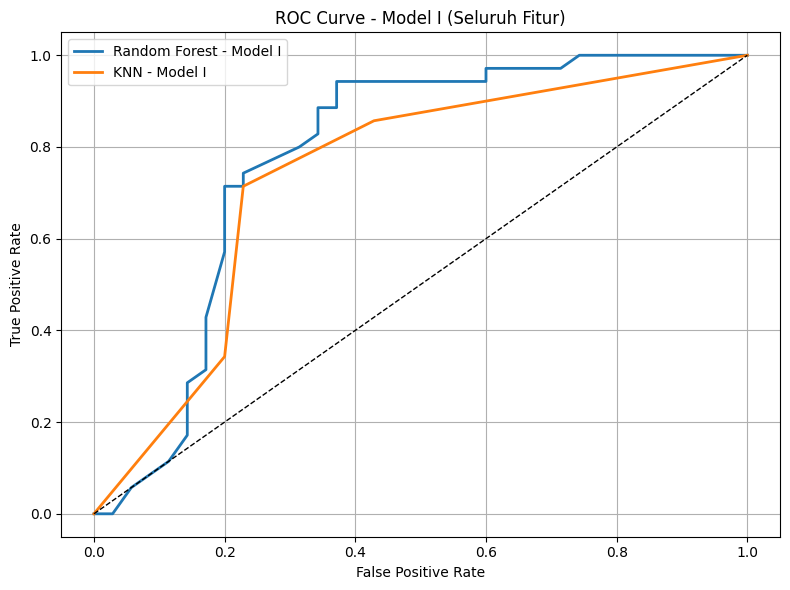

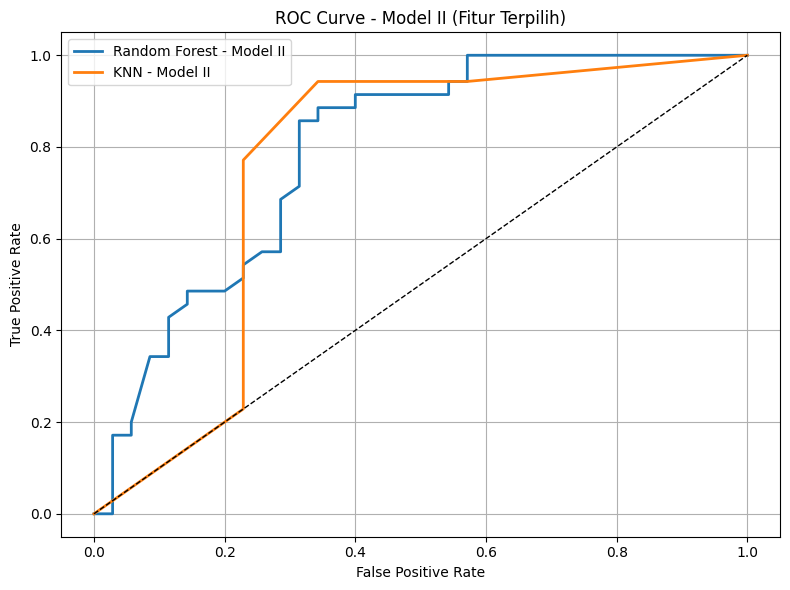

In [30]:
# --- ROC Curve: Model I (Seluruh Fitur) ---
fpr_rf1, tpr_rf1, _ = roc_curve(y1, y_score_rf)
fpr_knn1, tpr_knn1, _ = roc_curve(y1, y_score_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf1, tpr_rf1, label='Random Forest - Model I', linewidth=2)
plt.plot(fpr_knn1, tpr_knn1, label='KNN - Model I', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model I (Seluruh Fitur)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- ROC Curve: Model II (Fitur Terpilih) ---
fpr_rf2, tpr_rf2, _ = roc_curve(y2, y_score_rf2)
fpr_knn2, tpr_knn2, _ = roc_curve(y2, y_score_knn2)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf2, tpr_rf2, label='Random Forest - Model II', linewidth=2)
plt.plot(fpr_knn2, tpr_knn2, label='KNN - Model II', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model II (Fitur Terpilih)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Analisis

1. Random Forest (RF)
* Metode ini dipilih karena mampu menangani fitur yang banyak dan menghasilkan model yang stabil terhadap outlier dan overfitting. RF bekerja dengan membentuk banyak pohon keputusan dan menggabungkan hasil prediksi (voting). Dalam data dengan 70 fitur (Model I), RF dapat mengenali fitur penting secara otomatis melalui splitting informasi gain antar node. 
* Random Forest bekerja dengan membangun banyak pohon keputusan (decision tree) secara paralel dan menggabungkan hasil prediksinya menggunakan voting mayoritas (untuk klasifikasi). Setiap pohon dilatih menggunakan subset acak dari data (bootstrap sampling) dan subset acak dari fitur (feature bagging) pada setiap percabangan pohon.
* Dengan 70 fitur pada model awal, RF sangat berguna karena mampu mengurangi varians dan menangani fitur yang tidak relevan tanpa perlu seleksi fitur eksplisit. Metode ini tetap efektif pada model kedua (30 fitur terseleksi) karena mampu memperdalam struktur pohon pada fitur yang lebih informatif. Metode ini tetap efektif pada model kedua (24 fitur terseleksi) karena mampu memperdalam struktur pohon pada fitur yang lebih informatif. Parameter yang digunakan disini n_estimators = jumlah pohon, jadi semakin banyak pohon, hasil lebih stabil. Dan max_depth = mengontrol seberapa dalam pohon tumbuh sehingga mencegah overfitting.

2. K-Nearest Neighbors (KNN)
* KNN digunakan karena sederhana namun efektif untuk data terstandarisasi seperti ini. KNN menghitung jarak antar data, dan keputusan kelas diambil berdasarkan mayoritas tetangga terdekat. Pada dataset ini, KNN memanfaatkan hasil standarisasi untuk mengukur kemiripan antar sampel secara langsung tanpa asumsi distribusi data.
* KNN adalah metode non-parametrik yang mengklasifikasikan data berdasarkan jarak terdekat ke K tetangga paling mirip (biasanya Euclidean distance). Ia tidak melakukan pelatihan eksplisit, hanya menyimpan data training dan menghitung jarak saat prediksi. Model kedua (24 fitur hasil seleksi) membantu KNN karena mengurangi dimensi dan meningkatkan keakuratan dalam pengukuran kedekatan.
* Karena data sudah distandarisasi (dengan StandardScaler), KNN bekerja optimal dalam mengukur jarak antar data. Pada 70 fitur, kinerja bisa menurun karena efek “curse of dimensionality” (dimensi tinggi membuat jarak jadi kurang bermakna). Parameter yang digunakan n_neighbors = jumlah tetangga, nilai kecil sensitif terhadap noise, nilai besar cenderung smooth.